In [1]:
# load part of the toolkit
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
data = pd.read_csv('Coimbra_breast_cancer_dataset.csv')
data.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [3]:
# view info:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  
 3   Insulin         116 non-null    float64
 4   HOMA            116 non-null    float64
 5   Leptin          116 non-null    float64
 6   Adiponectin     116 non-null    float64
 7   Resistin        116 non-null    float64
 8   MCP.1           116 non-null    float64
 9   Classification  116 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 9.2 KB


In [4]:
# modify Classification so we have 0 and 1 values:

data['Classification'] = data['Classification'] - 1

# Define X and y:

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# train test split:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=639)

# standar scaler for z-score scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# lest´s start with a KNN classification. We use gridSearchCV in order to optimize the hyperparameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

knn_model= KNeighborsClassifier()

param_grid = {
                    'n_neighbors': [i for i in range(1,50)],
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                    'p': [1,2,3,4,5]                    
                }

grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(f'Best hyperparameters: {grid_search.best_params_}')

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
best_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC on the test set: {best_auc:.4f}')

Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
AUC on the test set: 0.8296


In [8]:
# now we can perform a PCA before KNN

from sklearn.decomposition import PCA

n_comp = []
auc = []
for i in range(1,10):

    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model= KNeighborsClassifier()

    param_grid = {
                        'n_neighbors': [i for i in range(1,50)],
                        'weights': ['uniform', 'distance'],
                        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                        'p': [1,2,3,4,5]                    
                    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train_pca, y_train)
    print(f'Best hyperparameters: {grid_search.best_params_} with {i} components')

    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]
    best_auc = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC on the test set: {best_auc:.4f}')

    n_comp.append(i)
    auc.append(best_auc)

Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 24, 'p': 1, 'weights': 'uniform'} with 1 components
AUC on the test set: 0.5852
Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 4, 'weights': 'uniform'} with 2 components
AUC on the test set: 0.6741
Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 22, 'p': 3, 'weights': 'distance'} with 3 components
AUC on the test set: 0.8000
Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 4, 'weights': 'distance'} with 4 components
AUC on the test set: 0.6889
Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'} with 5 components
AUC on the test set: 0.6148
Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'} with 6 components
AUC on the test set: 0.8074
Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 3, 'weights': 'distance'} with 7 components
AUC on the test set

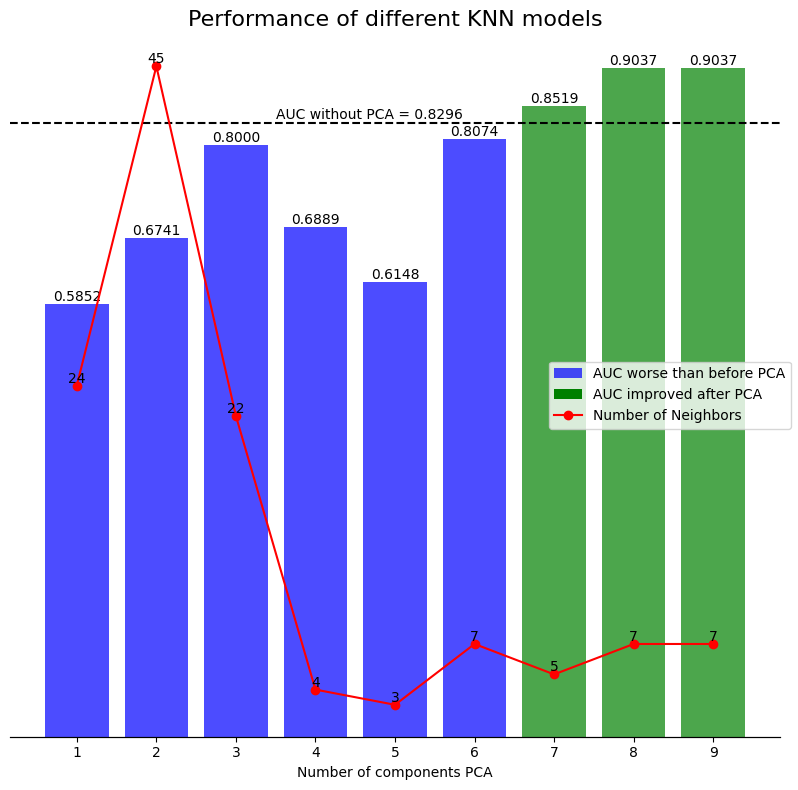

In [82]:
fig, ax1 = plt.subplots(figsize=(8,8))

num_neighbors = [24, 45, 22, 4, 3, 7, 5, 7, 7]

# Bars for AUC
bars = ax1.bar(n_comp, auc, color=np.where(np.array(auc) > 0.8296, 'green', 'blue'), alpha=0.7, label='AUC worse than before PCA')

# Bar labels
ax1.bar_label(bars, fmt='%.4f', label_type='edge', color='black')


# Create secondary axis for number of neighbors
ax2 = ax1.twinx()
ax2.plot(n_comp, num_neighbors, 'ro-', label='Number of Neighbors')

# Add labels to the neighbors points
for x, y in zip(n_comp, num_neighbors):
    ax2.text(x, y, f'{y}', ha='center', va='bottom', color='black')

# set axes configuration
ax1.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_xticks(n_comp)
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_xlabel('Number of components PCA')

# Title and legends
plt.title('Performance of different KNN models', fontsize=16)

handles, labels = ax1.get_legend_handles_labels()
handles += [plt.Rectangle((0,0),1,1,fc='green', edgecolor='none'), plt.Line2D([0], [0], color='red', marker='o', linestyle='-', label='Number of Neighbors')]
labels += ['AUC improved after PCA', 'Number of Neighbors']
fig.legend(handles, labels, loc='center right')

baseline_auc = 0.8296  # AUC of the model without PCA
ax1.axhline(y=baseline_auc, color='black', linestyle='--', label='Baseline (Without PCA)')
ax1.text(3.5, baseline_auc + 0.01, f'AUC without PCA = {baseline_auc:.4f}', color='black', va='center')
fig.tight_layout()

plt.show()


Conclusions:  
Best Model: KNN {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 3, 'weights': 'distance'} with 8 PCA components.  
AUC on the test set: 0.9037